## Trading Strategy Entry Post Report 

In the previous strategy, the trades were entered and exited based on sentiment score of the entire FOMC meeting and price trend. In this notebook, you will learn to create and backtest a trading strategy based just on sentiment score of the FOMC meeting without including the price trend. The notebook is structured as follows:

1. [Read the Data](#read)
2. [Trading Strategy](#tradingstrategy)
3. [Trade Level Analytics](#tradelevelanalytics)
4. [Performance Analysis](#performance)
5. [Conclusion and Next Steps](#conclusion)


## Import Libraries

In [1]:
# Import the 'datetime' module to work with date and time objects in Python
import datetime

# For data manipulation
import pandas as pd
import numpy as np

# Import utility functions 
import sys
sys.path.append('..')
from data_modules.trade_fed_utils import trade_analytics, update_signal_column, get_performance_metrics

# For data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# To ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\varun\anaconda3\envs\quantra_py\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<a id='read'></a>
## Read the Data

We have saved the FOMC sentiment score data in a CSV file named `fomc_sentiment_score_spy_ohlc_jan22_to_jul24.csv`. You can read the file using the `read_csv()` method. 


In [2]:
daily_text = pd.read_csv(
    '../data_modules/daily_sentiment_score_FOMC_Transcript.csv', index_col=0)
daily_text.head()

,script,sentiment_score
timestamp,,
2022-01-26 19:36:00+00:00,"Good afternoon. At the Federal Reserve, we are...",0.071792
2022-03-16 18:36:00+00:00,Good afternoon. I w ant to begin by acknowledg...,0.021699
2022-05-04 18:36:00+00:00,Good afternoon. It’s nice to see everyone in p...,0.072392
2022-06-15 18:38:00+00:00,Good afternoon. I will begin with one overarch...,0.213533
2022-07-27 18:36:00+00:00,Good afternoon. My colleagues and I are strong...,0.092692


Import the minute data of SPY ETF with price trend information from the csv file `spy_ohlc_price_trend_jan22_to_jul24`.

In [3]:
# Read the CSV file containing minute-level OHLC price trend data for SPY from Jan 2022 to Jul 2024
# The first column (index_col=0) is set as the index of the dataframe
minute_data = pd.read_csv(
    '../data_modules/spy_ohlc_jan22_to_jul24.csv', index_col=0)

minute_data.index = pd.to_datetime(minute_data.index)

# Display the first few rows of the dataframe to inspect the data
minute_data.head()

,open,high,low,close
timestamp,,,,
2022-01-26 00:00:00+00:00,435.17,435.22,435.15,435.15
2022-01-26 00:01:00+00:00,435.13,435.13,434.80,434.80
2022-01-26 00:02:00+00:00,434.83,434.96,434.80,434.96
2022-01-26 00:03:00+00:00,434.86,434.86,434.66,434.66
2022-01-26 00:04:00+00:00,434.55,434.55,434.23,434.30


<a id='tradingstrategy'></a>
## Trading Strategy

A long position is taken when the sentiment score of the FOMC report is more than the sentiment score threshold of 0.1. Similarly, a short position is taken when the sentiment score of the FOMC report is less than the sentiment score threshold of -0.1. The trades are closed at the end of the day.

Create a dataframe `trade_sheet` to store all trade-related data. Initialise the `current_position` variable to track whether a trade is open (1 for a long position) or closed (0 for no position). Define variables to store key trade information, including `entry_datetime`, `entry_price`, `exit_datetime`, and `exit_price`, which will be populated as trades are executed. Additionally, set the `sentiment_score_threshold` to 0.1 to trigger entering or exiting trades based on sentiment analysis.

In [4]:
# Create a dataframe 'trade_sheet' to store the trades
trade_sheet = pd.DataFrame()

# Initialise the current_position as '0'
current_position = 0

# Define a variable to store the long entry date
entry_datetime = ''

# Define a variable to store the long entry price
entry_price = ''

# Define a variable to store the long exit date
exit_datetime = ''

# Define a variable to store the long exit price
exit_price = ''

sentiment_score_threshold = 0.1 # Strategy-1: Enter long / short when rolling sentiment score crosses a threshold

# Iterate over the dates in the dataframe 'data'
for i in daily_text.index:
    print('__________')
    print('opening position')
    
    if (daily_text.loc[i]['sentiment_score'] > 0):
        print('opening long position')
        current_position = 1
        # Define the variable 'entry_date'
        entry_datetime = i
        entry_price = minute_data.loc[i].close
        exit_datetime = minute_data.loc[str(i)[:10]][-2:-1].index[0]
        exit_price = minute_data.loc[str(i)[:10]][-2:-1].close[0]
        
        # Append the details of this trade to the 'trade_sheet' dataframe
        trade_sheet = trade_sheet.append(
            [(current_position, entry_datetime, entry_price, exit_datetime, exit_price)], ignore_index=True)

    elif (daily_text.loc[i]['sentiment_score'] < 0):
        print('opening short position')
        current_position = -1
        # Define the variable 'entry_date'
        entry_datetime = i
        entry_price = minute_data.loc[i].close
        exit_datetime = minute_data.loc[str(i)[:10]][-2:-1].index[0]
        exit_price = minute_data.loc[str(i)[:10]][-2:-1].close[0]
        
        # Append the details of this trade to the 'trade_sheet' dataframe
        trade_sheet = trade_sheet.append(
            [(current_position, entry_datetime, entry_price, exit_datetime, exit_price)], ignore_index=True)
        
 
        
# Define the names of columns in 'trade_sheet' dataframe
trade_sheet.columns = ['Position', 'Entry Datetime',
                       'Entry Price', 'Exit Datetime', 'Exit Price']
trade_sheet['pnl'] = trade_sheet['Position'] * (trade_sheet['Exit Price'] - trade_sheet['Entry Price'])

trade_sheet.tail()

__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position
__________
opening position
opening long position


,Position,Entry Datetime,Entry Price,Exit Datetime,Exit Price,pnl
13,1,2024-01-31 19:35:00+00:00,486.73,2024-01-31 23:55:00+00:00,483.74,-2.99
14,1,2024-03-20 18:37:00+00:00,517.22,2024-03-20 23:58:00+00:00,521.84,4.62
15,1,2024-05-01 18:36:00+00:00,502.81,2024-05-01 23:58:00+00:00,502.32,-0.49
16,1,2024-06-12 18:37:00+00:00,542.52,2024-06-12 23:58:00+00:00,542.18,-0.34
17,1,2024-07-31 18:35:00+00:00,550.89,2024-07-31 23:58:00+00:00,553.40,2.51


<a id='tradelevelanalytics'></a>

## Trade Level Analytics

Generate performance analytics for a trading strategy using the `trade_analytics` function to calculate various trade level statistics. Save the output dataframe with trade level analytics in the `trade_level_analytics` dataframe.

In [5]:
# Perform trade analytics on the 'trade_sheet' dataframe using the function 'trade_analytics' to compute various trade level analytics
trade_level_analytics = trade_analytics(trade_sheet) 

# Display the results of the trade-level analytics to review performance metrics
trade_level_analytics

,Strategy
Total pnl,5.08
total_trades,18
Number of Winners,10
Number of Losers,8
Win (%),55.56
Loss (%),44.44
per_trade_pnl_winners,4.15
per_trade_pnl_losers,4.56
Average holding time,0 days 05:08:16.666666666


### Update Trading Signals in DataFrame

Similar to the previous notebook, update the signal column in the `minute_data` dataframe using the function `update_signal_column`.

In [6]:
# Initiate the 'signal' column
minute_data['signal'] = 0

# Update the 'minute_data' DataFrame by applying the 'update_signal_column' function
minute_data = update_signal_column(trade_sheet, minute_data)

# Display the first few rows of the updated 'minute_data' to verify the signal column update
minute_data.head()

,open,high,low,close,signal
timestamp,,,,,
2022-01-26 00:00:00+00:00,435.17,435.22,435.15,435.15,0
2022-01-26 00:01:00+00:00,435.13,435.13,434.80,434.80,0
2022-01-26 00:02:00+00:00,434.83,434.96,434.80,434.96,0
2022-01-26 00:03:00+00:00,434.86,434.86,434.66,434.66,0
2022-01-26 00:04:00+00:00,434.55,434.55,434.23,434.30,0


<a id='performance'></a>
## Performance Analysis

Use the function `get_performance_metrics` to calculate the performance measures and analyse the strategy.

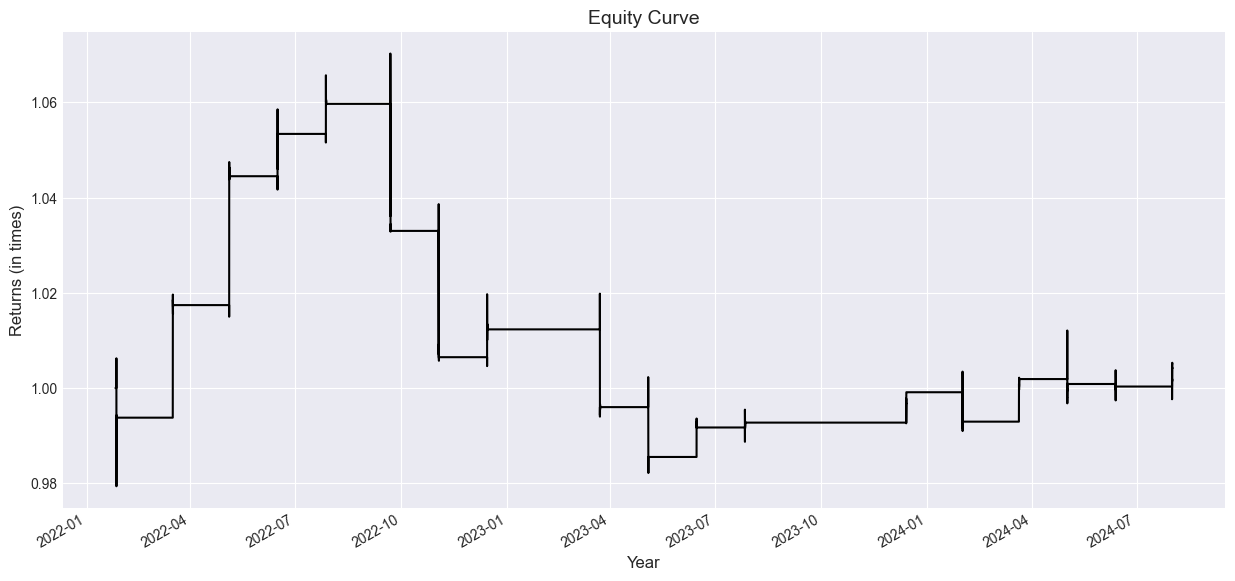

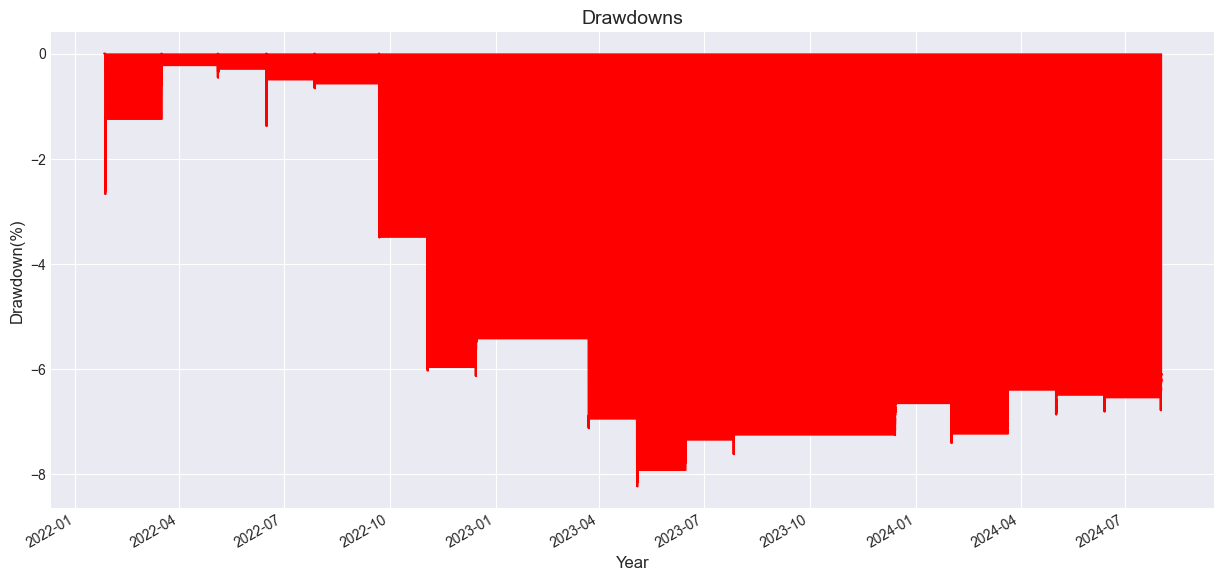

                 Strategy
Sharpe Ratio         0.35
Maximum Drawdown   -8.23%


In [7]:
# Call the function
get_performance_metrics(minute_data.dropna())

The strategy using the sentiment score of FOMC report without the price trend generated a Sharpe ratio of 0.35 with a maximum drawdown of 8.23%. It can be observed that there is no improvement in the performance compared to the same strategy including the price trend.
<a id='conclusion'></a>

## Conclusion and Next Steps
In this notebook, you tested the variation of a trading strategy based on the sentiment score of the entire FOMC report. <br><br>